# PSO vs Breadth-First Search (BFS) on Knapsack
Focus:
- **Convergence speed**: how fast each method improves the best-so-far profit;
- **Computational complexity**: wall–clock time per run and rough time/space scaling;
- **Robustness**: performance across multiple PSO runs (different random seeds);
- **Scalability**: how performance changes with problem size (number of items).

In [1]:
import time
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional, Any

import numpy as np
import matplotlib.pyplot as plt

# Project imports
from swarm_algo.pso import ParticleSwarmOptimizer
from problem.knapsack import Knapsack
from search_algo.bfs import BreadthFirstSearch  

OUT_PATH = "../imgs/pso_knapsack/"  
import os
if not os.path.exists(OUT_PATH):
    os.makedirs(OUT_PATH)

In [2]:
# ---- Knapsack helpers ----

KNAPSACK_DATA_FOLDER = "../data/knapsack"  


def load_knapsack_problem(problem_number: int) -> Tuple[Knapsack, int, float]:
    """
    Load a knapsack instance and return (problem, n_items, optimal_profit).
    """
    prob = Knapsack(PROBLEM_FOLDER=KNAPSACK_DATA_FOLDER, PROBLEM=problem_number)
    n_items = len(prob.items)
    # Ground-truth optimal profit from provided solution
    opt_profit = prob.calculate_fitness(prob.solution)
    return prob, n_items, float(opt_profit)


def decode_position_to_solution(x: np.ndarray, n_items: int) -> np.ndarray:
    """
    Map a continuous vector in [0,1]^d to a 0/1 solution vector.
    """
    x = np.asarray(x, dtype=float)
    if x.shape[0] != n_items:
        raise ValueError(f"Expected dimension {n_items}, got {x.shape[0]}")
    return (x > 0.5).astype(int)

In [3]:
# ---- Metrics used across both algorithms ----

def convergence_auc(history: List[float]) -> float:
    """
    Area under curve of best-so-far loss (lower is better).
    Here we will usually pass loss = -profit, so decreasing curve = better.
    """
    y = np.asarray(history, dtype=float)
    x = np.arange(len(y))
    return float(np.trapezoid(y, x))


def iters_to_epsilon(history: List[float], eps: float) -> Optional[int]:
    """
    First iteration where best-so-far loss <= eps. Return None if never reached.
    """
    y = np.asarray(history, dtype=float)
    idx = np.where(y <= eps)[0]
    return int(idx[0]) if idx.size > 0 else None


def pad_history(histories: List[List[float]]) -> np.ndarray:
    """
    Pad variable-length histories to the same length with the last value.
    """
    max_len = max(len(h) for h in histories)
    padded = np.zeros((len(histories), max_len), dtype=float)
    for i, h in enumerate(histories):
        last = h[-1]
        padded[i, :len(h)] = h
        if len(h) < max_len:
            padded[i, len(h):] = last
    return padded


def summarize(values: List[float]) -> Tuple[float, float]:
    a = np.asarray(values, float)
    return float(a.mean()), float(a.std())

In [4]:
# ---- PSO on Knapsack ----

def run_pso_knapsack(
    prob: Knapsack,
    max_iters: int,
    seed: int,
    n_particles: int = 50,
    mode: str = "constriction",
    phi1: float = 2.05,
    phi2: float = 2.05,
    chi: float = 0.729,
    topology: str = "ring",
    ring_neighbors: int = 2,
    velocity_clamp: float = 0.5,
    boundary_mode: str = "clip",
) -> Dict[str, Any]:
    """
    Run one PSO trajectory on Knapsack and collect metrics.

    We optimize over a continuous [0,1]^d space and threshold to 0/1 decisions.
    Objective is to MAXIMIZE profit, but PSO minimizes `loss = -profit`.
    """
    n_items = len(prob.items)
    bounds = [(0.0, 1.0)] * n_items

    def objective(x: np.ndarray) -> float:
        sol = decode_position_to_solution(x, n_items)
        profit = prob.calculate_fitness(sol)
        return -float(profit)  # minimize negative profit

    t0 = time.perf_counter()
    pso = ParticleSwarmOptimizer(
        objective=objective,
        bounds=bounds,
        n_particles=n_particles,
        max_iters=max_iters,
        mode=mode,
        phi1=phi1,
        phi2=phi2,
        chi=chi,
        topology=topology,
        ring_neighbors=ring_neighbors,
        velocity_clamp=velocity_clamp,
        boundary_mode=boundary_mode,
        seed=seed,
        problem_type="continuous",
        enable_position_history=False,
        track_positions=False,
        early_stopping_rounds=None,
        tol=1e-12,
    )
    best_x, best_loss, info = pso.optimize()
    dt = time.perf_counter() - t0

    best_sol = decode_position_to_solution(best_x, n_items)
    best_profit = float(prob.calculate_fitness(best_sol))

    # Convert PSO's loss history to profit history
    history_loss = list(info.history_best_f)
    history_profit = [-v for v in history_loss]

    return dict(
        best_profit=best_profit,
        history_profit=history_profit,
        time=dt,
        n_iter=info.n_iter,
    )


In [5]:
# ----  BFS on Knapsack ----

class InstrumentedBFS(BreadthFirstSearch):
    """
    Breadth-first search that also records best-so-far fitness over iterations.
    """
    def run(
        self,
        max_iterations: Optional[int] = 10000,
        visualize: bool = False,
    ):
        iterations = 0
        history_best: List[float] = []

        while self.queue and (max_iterations is None or iterations < max_iterations):
            current_state = self.queue.popleft()

            if current_state not in self.visited:
                self.visited.add(current_state)

                if self.fitness_function:
                    current_fitness = self.fitness_function(current_state)
                    if current_fitness > self.best_fitness:
                        self.best_fitness = current_fitness
                        self.best_state = current_state

                history_best.append(self.best_fitness)

                neighbors = self.get_neighbors(current_state)
                for neighbor in neighbors:
                    if neighbor not in self.visited:
                        self.queue.append(neighbor)
            iterations += 1

        return self.best_state, self.best_fitness, history_best


def run_bfs_knapsack(
    prob: Knapsack,
    max_iterations: Optional[int] = None,
) -> Dict[str, Any]:
    """
    Run (instrumented) BFS on Knapsack and collect metrics.

    BFS explores the discrete state space level by level from the empty knapsack.
    We treat the fitness as the knapsack profit and record the best-so-far profit.
    """
    n_items = len(prob.items)
    start_state = tuple([0] * n_items)  # empty knapsack

    def get_neighbors(state: Any) -> List[Any]:
        # `state` is a tuple of 0/1; Knapsack.get_neighbors expects a list[int]
        return prob.get_neighbors(list(state))

    bfs = InstrumentedBFS(start_state=start_state, get_neighbors=get_neighbors)
    bfs.set_fitness_function(lambda state: float(prob.calculate_fitness(list(state))))

    t0 = time.perf_counter()
    best_state, best_profit, history_profit = bfs.run(max_iterations=max_iterations)
    dt = time.perf_counter() - t0

    return dict(
        best_profit=float(best_profit),
        history_profit=list(history_profit),
        time=dt,
        n_iter=len(history_profit),
    )

In [6]:
# ---- Multi-run wrappers for robustness & statistics ----

@dataclass
class KnapRunSummary:
    method: str
    problem: int
    n_items: int
    max_steps: Optional[int]
    n_runs: int
    best_profit_mean: float
    best_profit_std: float
    rel_mean: float
    rel_std: float
    auc_mean: float
    auc_std: float
    time_mean: float
    time_std: float
    iters_eps_mean: float
    iters_eps_std: float
    hit_rate: float


EPS_RATIO = 0.99  # how close to optimal profit we consider "good enough"


def run_many_knapsack(
    method: str,
    problem_number: int,
    n_runs: int,
    base_seed: int = 0,
    max_iters_pso: int = 400,
    n_particles: int = 50,
    max_iterations_bfs: Optional[int] = None,
) -> Tuple[KnapRunSummary, Dict[str, Any]]:
    """
    Run PSO or BFS multiple times on a given knapsack instance.
    """
    prob, n_items, opt_profit = load_knapsack_problem(problem_number)

    best_profits: List[float] = []
    rels: List[float] = []
    aucs: List[float] = []
    times: List[float] = []
    iters_eps: List[float] = []
    hits: List[float] = []
    histories_profit: List[List[float]] = []
    histories_loss: List[List[float]] = []

    for i in range(n_runs):
        seed = base_seed + i

        if method.lower() == "pso":
            out = run_pso_knapsack(
                prob=prob,
                max_iters=max_iters_pso,
                seed=seed,
                n_particles=n_particles,
            )
        elif method.lower() == "bfs":
            # BFS is deterministic; seed is unused
            out = run_bfs_knapsack(
                prob=prob,
                max_iterations=max_iterations_bfs,
            )
        else:
            raise ValueError("method must be 'pso' or 'bfs'")

        hp = out["history_profit"]
        histories_profit.append(hp)
        hl = [-v for v in hp]  # loss = -profit
        histories_loss.append(hl)

        best_profit = float(out["best_profit"])
        best_profits.append(best_profit)
        rels.append(best_profit / opt_profit)

        times.append(out["time"])
        aucs.append(convergence_auc(hl))

        eps_target = -(EPS_RATIO * opt_profit)
        it_eps = iters_to_epsilon(hl, eps=eps_target)
        if it_eps is None:
            iters_eps.append(np.nan)
            hits.append(0.0)
        else:
            iters_eps.append(float(it_eps))
            hits.append(1.0)

    best_mean, best_std = summarize(best_profits)
    rel_mean, rel_std = summarize(rels)
    auc_mean, auc_std = summarize(aucs)
    time_mean, time_std = summarize(times)

    it_arr = np.asarray(iters_eps, float)
    it_valid = it_arr[~np.isnan(it_arr)]
    if it_valid.size > 0:
        it_mean = float(it_valid.mean())
        it_std = float(it_valid.std())
    else:
        it_mean = np.nan
        it_std = np.nan

    hit_rate = float(np.mean(hits)) if len(hits) > 0 else 0.0

    summary = KnapRunSummary(
        method=method,
        problem=problem_number,
        n_items=n_items,
        max_steps=max_iters_pso if method.lower() == "pso" else max_iterations_bfs,
        n_runs=n_runs,
        best_profit_mean=best_mean,
        best_profit_std=best_std,
        rel_mean=rel_mean,
        rel_std=rel_std,
        auc_mean=auc_mean,
        auc_std=auc_std,
        time_mean=time_mean,
        time_std=time_std,
        iters_eps_mean=it_mean,
        iters_eps_std=it_std,
        hit_rate=hit_rate,
    )

    raw = dict(
        histories_profit=histories_profit,
        histories_loss=histories_loss,
        best_profits=best_profits,
        rels=rels,
        times=times,
        aucs=aucs,
        iters_eps=iters_eps,
        hits=hits,
        opt_profit=float(opt_profit),
        n_items=n_items,
    )
    return summary, raw

In [7]:
# ---- Plot helpers ----

def plot_convergence_profit(
    histories_profit_pso: List[List[float]],
    histories_profit_bfs: List[List[float]],
    title: str,
    save_path: Optional[str] = None,
):
    Hp = pad_history(histories_profit_pso)
    Hb = pad_history(histories_profit_bfs)

    mean_pso = Hp.mean(axis=0)
    mean_bfs = Hb.mean(axis=0)

    plt.figure(figsize=(7, 4))
    plt.plot(mean_pso, label="PSO")
    plt.plot(mean_bfs, label="BFS")
    plt.xlabel("Iteration / expansion step")
    plt.ylabel("Best-so-far profit")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def plot_scalability_curve(
    x_vals,
    vals_pso,
    vals_bfs,
    xlabel: str,
    ylabel: str,
    title: str,
    logy: bool = False,
    save_path: Optional[str] = None,
):
    plt.figure(figsize=(7, 4))
    if logy:
        plt.semilogy(x_vals, vals_pso, marker="o", label="PSO")
        plt.semilogy(x_vals, vals_bfs, marker="o", label="BFS")
    else:
        plt.plot(x_vals, vals_pso, marker="o", label="PSO")
        plt.plot(x_vals, vals_bfs, marker="o", label="BFS")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

## 1) Convergence speed, robustness, and time on a single instance

Running PSO (20 runs) and BFS (1 run) on Knapsack p01 ...

=== PSO summary ===
KnapRunSummary(method='pso', problem=1, n_items=10, max_steps=400, n_runs=20, best_profit_mean=307.75, best_profit_std=5.448623679425842, rel_mean=0.9959546925566343, rel_std=0.017633086341183962, auc_mean=-122319.775, auc_std=2198.290321334969, time_mean=0.13608229999990726, time_std=0.005628348714297167, iters_eps_mean=15.473684210526315, iters_eps_std=22.78588764784635, hit_rate=0.95)

=== BFS summary ===
KnapRunSummary(method='bfs', problem=1, n_items=10, max_steps=None, n_runs=1, best_profit_mean=309.0, best_profit_std=0.0, rel_mean=1.0, rel_std=0.0, auc_mean=-30548.5, auc_std=0.0, time_mean=0.0008769999985815957, time_std=0.0, iters_eps_mean=141.0, iters_eps_std=0.0, hit_rate=1.0)


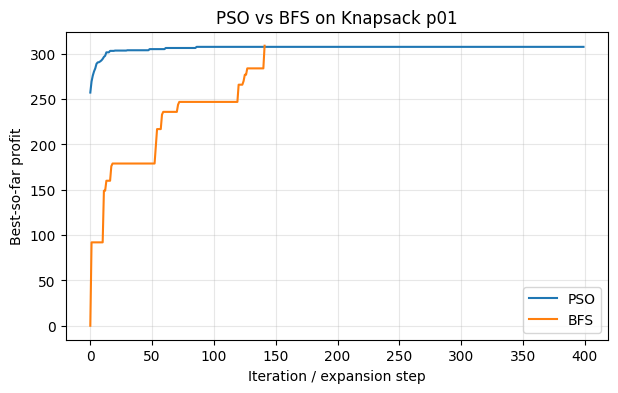

In [8]:
PROBLEM = 1          # which pXX instance to use
MAX_ITERS_PSO = 400
N_RUNS_PSO = 20
N_RUNS_BFS = 1       # BFS is deterministic; 1 run is enough
MAX_ITERATIONS_BFS = None  # None = full search (may be expensive for large instances)

print(f"Running PSO ({N_RUNS_PSO} runs) and BFS ({N_RUNS_BFS} run) on Knapsack p{PROBLEM:02d} ...")

pso_summary, pso_raw = run_many_knapsack(
    method="pso",
    problem_number=PROBLEM,
    n_runs=N_RUNS_PSO,
    base_seed=0,
    max_iters_pso=MAX_ITERS_PSO,
    n_particles=50,
)

bfs_summary, bfs_raw = run_many_knapsack(
    method="bfs",
    problem_number=PROBLEM,
    n_runs=N_RUNS_BFS,
    max_iterations_bfs=MAX_ITERATIONS_BFS,
)

print("\n=== PSO summary ===")
print(pso_summary)
print("\n=== BFS summary ===")
print(bfs_summary)

plot_convergence_profit(
    histories_profit_pso=pso_raw["histories_profit"],
    histories_profit_bfs=bfs_raw["histories_profit"],
    title=f"PSO vs BFS on Knapsack p{PROBLEM:02d}",
    save_path=OUT_PATH + f"convergence.png"
)

## 2) Scalability with problem size (#items)


>> Problem p01

>> Problem p02

>> Problem p03

>> Problem p04


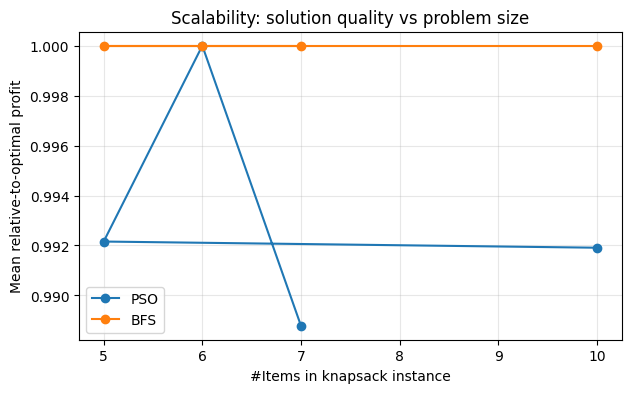

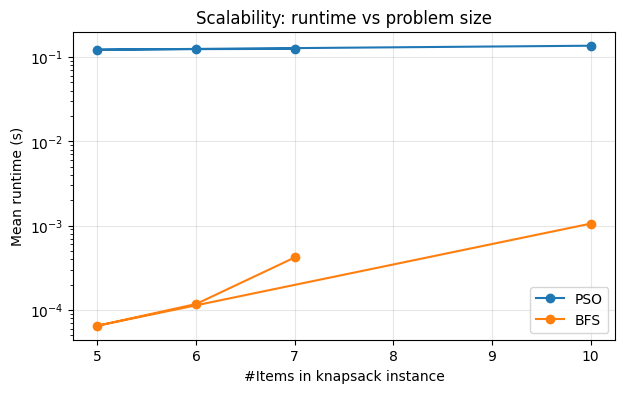

In [9]:
PROBLEMS = [1, 2, 3, 4]        # adjust depending on dataset size
MAX_ITERS_PSO_SCAL = 400
N_RUNS_PSO_SCAL = 10
N_RUNS_BFS_SCAL = 1

items_list = []
rel_pso_list = []
rel_bfs_list = []
time_pso_list = []
time_bfs_list = []

for prob_id in PROBLEMS:
    print(f"\n>> Problem p{prob_id:02d}")
    pso_summary, _ = run_many_knapsack(
        method="pso",
        problem_number=prob_id,
        n_runs=N_RUNS_PSO_SCAL,
        base_seed=1234,
        max_iters_pso=MAX_ITERS_PSO_SCAL,
        n_particles=50,
    )
    bfs_summary, _ = run_many_knapsack(
        method="bfs",
        problem_number=prob_id,
        n_runs=N_RUNS_BFS_SCAL,
        max_iterations_bfs=None,  # full search; may be slow for large instances
    )

    items_list.append(pso_summary.n_items)
    rel_pso_list.append(pso_summary.rel_mean)
    rel_bfs_list.append(bfs_summary.rel_mean)
    time_pso_list.append(pso_summary.time_mean)
    time_bfs_list.append(bfs_summary.time_mean)

plot_scalability_curve(
    x_vals=items_list,
    vals_pso=rel_pso_list,
    vals_bfs=rel_bfs_list,
    xlabel="#Items in knapsack instance",
    ylabel="Mean relative-to-optimal profit",
    title="Scalability: solution quality vs problem size",
    logy=False,
    save_path=OUT_PATH + "scalability_quality.png"
)

plot_scalability_curve(
    x_vals=items_list,
    vals_pso=time_pso_list,
    vals_bfs=time_bfs_list,
    xlabel="#Items in knapsack instance",
    ylabel="Mean runtime (s)",
    title="Scalability: runtime vs problem size",
    logy=True,
    save_path=OUT_PATH + "scalability_time.png"
)
